# Case 1: Computation on value graph for CareHD

1. Martin Molan
1. Gregor Molan

+ 2023-01-02 based on computation on value graph for vINCI
+ 2022-01-02
    * new weight matrices
    * conda activate tse_model
+ 2022-01-03
    * Add table of contents (https://jupyter-contrib-nbextensions.readthedocs.io)
    * brew install graphviz
+ 2022-01-04
    * Corrected calculation of "Backend input gradients":
        * from
            * `-lst_model_weights`
        * to
            * `lst_model_weights[1].dot(layer2_grad.T`
+ 2022-01-06
    * Cleanup error messages on Apple M2
+ 2022-01-07
    * New model with additional layers
    * Added relu function after "subtract" layer
+ 2022-01-14
    * Variable names present variable types
      * `d_` for OrderedDict
      * `f_` for function
      * `fl_` for float
      * `fnal_` for functional
      * `lst_` for list
      * `m_` for module
      * `str_` for string
      * `t_` for type
      * `vec_` for vector (array, ndarray)


## Prerequisites

### Install all needed packages on MacOS

In [1]:
!pip install keract

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Prerequisites (imports)

In [2]:
# Ensure that a GPU version of TensorFlow ONLY runs on CPU

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# no need to import os module:
%env CUDA_VISIBLE_DEVICES=-1

env: CUDA_VISIBLE_DEVICES=-1


In [3]:
# imports from keras
from keras.layers import Layer as t_keras_layers_Layer;
from keras.layers import Input as f_keras_layers_Input;
from keras.layers import Dense as t_keras_layers_Dense;
from keras.layers import Activation as t_keras_layers_Activation;
from keras.layers import Multiply as t_keras_layers_Multiply;
from keras.layers import subtract as f_keras_layers_subtract;
from keras.models import Model as t_keras_models_Model;
from keras.optimizers import SGD as t_keras_optimizers_SGD;
from keras.utils import plot_model as f_keras_utils_plot_model;

# imports from keract
from keract import get_activations as f_keract_get_activations;
from keract import get_gradients_of_activations as f_keract_get_gradients_of_activations;

# import from numpy
from numpy import array as numpy_array;

# imports from tensorflow
from tensorflow import ones_initializer as t_tensorflow_ones_initializer;
# from tensorflow import Variable as f_tensorflow_Variable;
from tensorflow import random_normal_initializer as t_tensorflow_random_normal_initializer;
from tensorflow import matmul as f_matmul;
from tensorflow import compat as m_tensorflow_compat;

# import from pyplot from matplotlib
from matplotlib.pyplot import plot as f_matplotlib_pyplot_plot;
from matplotlib.pyplot import ylabel as f_matplotlib_pyplot_ylabel;
from matplotlib.pyplot import xlabel as f_matplotlib_pyplot_xlabel;
from matplotlib.pyplot import legend as f_matplotlib_pyplot_legend;
from matplotlib.pyplot import savefig as f_matplotlib_pyplot_savefig;
from matplotlib.pyplot import figure as f_matplotlib_pyplot_figure;

### Ignore warnings on Apple M2

In [4]:
from warnings import filterwarnings as f_warnings_filterwarnings;
# f_warnings_filterwarnings(action='once')
f_warnings_filterwarnings('ignore')

## Value graph definition

### Definition of model topology

### Definition of input parameters

In [5]:
lst_model_weights =[ 
numpy_array([[1],  # reqirement functionalities
          [1],
          [1]]),
numpy_array([0]),  # bias for reqirement functionalities
numpy_array([[1],  # backend functionalities
          [0.7],
          [0.2],
          [0.3]]),
numpy_array([0]),  # bias for backend functionalities
numpy_array([[0.3 , 0.6,  0.1 ]]), # data collection relations (storage, processing, mgmt)
numpy_array([0, 0, 0]), # bias for data collection
numpy_array([[1],  # storage
          [1],  # processing
          [1]]),# mgmt
numpy_array([0]),  # bias
numpy_array([[0.1, 0.1,  0.3  , 0.1, 0.4]]), # generating interventions 
numpy_array([0, 0, 0, 0, 0]), # bias generating interventions
numpy_array([[0.7],   # website
          [0.6],   # mobile app
          [0.9],   # 3rd party api
          [0.9],   # call support
          [1]]), # new knowledge
numpy_array([0])]   # bias for 

### Definition of input variables

In [6]:
#
# Input variables in vectors for Requirements (vec_R) and Bias (vec_B)
#
vec_R = numpy_array([[0.40,0.35,0.25]]);
vec_B = numpy_array([[0.5,0.5,0.5,0.5]]);
vec_B = numpy_array([[0,0,0,0]]);
# vec_B = numpy_array([[1,1,1,1]]);

### Custom activation function

In [7]:
#
# NOTE: fl_gl_percentage is global variable!
#
def f_tradeoff(x):
    n = 1 / (1-fl_gl_percentage);
    y = x - x**n/n;
    return(y)

### Definition of learning rate

In [8]:
#
# Definition of learning rate for "Gradient descent (with momentum) optimizer"
#
fl_my_learning_rate = 0.01;

### Setup the model

In [9]:
# from tensorflow.python.ops.math_ops import dense_bincount
#
# Input:
#  fl_gl_percentage
#  lst_model_weights

# input global variable 
#  fl_gl_percentage ... percentage in activation function

# global variables used for setup custom layer names of the model 
str_relu_activ_f_name = 'relu_activ';   
str_tradeoff_activ_f_name = 'tradeoff_activ';
str_layer3_name  = 'layer3_subgraph';
str_layer4_name = 'stv_layer4_name';
str_layer5_name = 'str_layer5_name';
str_output_name = 'output_subgraph';

#
# Input parameters
#  lst_model_weights ... graph layer3 weights, topology of the model
#
# Return
#  Keras Model class
#
def f_setup_model(lst_model_weights):
    
    # Following variables can have arbitrary values (but distinguish)
    #   for custom layer names of the model
    requ_name = 'requirement_subgraph_0';
    back_name = 'backend_subgraph_0';
    
    # --- Model definition ---
    # Define two sets of input layers
    input_req = f_keras_layers_Input(shape=(3,),name=requ_name)
    dense_req = t_keras_layers_Dense(1, name='req_dense')(input_req)


    input_backend = f_keras_layers_Input(shape=(4,), name = back_name)
    dense_backend = t_keras_layers_Dense(1, name ='back_dense')(input_backend)
    
    # Define layer 2
    # The second layer (layer2) consists of 'requ_back',
    #    (where name is inherited from class RequBack),
    # relu activation function (str_relu_activ_f_name)
    # and our custom trade-off function (str_tradeoff_activ_f_name).
    

        
    dense_relu = t_keras_layers_Activation(
                                         'relu',
                                          name=str_relu_activ_f_name
                                        )(dense_backend);

    layer_multiply = t_keras_layers_Multiply()([dense_req,dense_backend])

    
    
    layer_substract = f_keras_layers_subtract([dense_req,layer_multiply])


    layer_relu = t_keras_layers_Activation(
                                         'relu',
                                          name=str_relu_activ_f_name
                                        )(layer_substract);
    #requ_back = t_RequBack(1, 3, 4)([input_req,input_backend]);



    layer2 = t_keras_layers_Activation(
                                   f_tradeoff,
                                   name=str_tradeoff_activ_f_name
                                  )(layer_relu);

    # Define 3. layer
    layer3 = t_keras_layers_Dense(3, name = str_layer3_name)(layer2);
    
    # Define 4. layer
    layer4 = t_keras_layers_Dense(1, name = str_layer4_name)(layer3);
    
    # Define 5. layer
    layer5 = t_keras_layers_Dense(5, name = str_layer5_name)(layer4);

    # Define Value layer (6. layer = output layer)
    output = t_keras_layers_Dense(1, name = str_output_name)(layer5);

    # --- Model compile ---
    my_model = t_keras_models_Model(
        inputs=[input_req, input_backend],
        outputs=output
    )
    my_optimizer = t_keras_optimizers_SGD(learning_rate=fl_my_learning_rate)
    my_model.compile(optimizer=my_optimizer, loss='mse');
    
    # --- Set model weights ---
    my_model.set_weights(lst_model_weights);
    
    return(my_model);        

In [10]:
#
# To use keract.get_gradients_of_activations in computing gradients
# we should disable TF eager mode 
#
m_tensorflow_compat.v1.disable_eager_execution()

In [11]:
# DeepReg logging
# “0”	Log all messages, equivalent to logging.DEBUG. Same as log level “1”.
# “1”	Log all messages, equivalent to logging.DEBUG.
# “2”	Log all messages except DEBUG, equivalent to logging.INFO. (default)
# “3”	Log all messages except DEBUG and INFO, equivalent to logging.WARNING.
# “4”	Log all messages except DEBUG, INFO, and WARNING, equivalent to logging.ERROR.
# “5”	Log all messages except DEBUG, INFO, WARNING, and ERROR, equivalent to logging.CRITICAL.

TF_CPP_MIN_LOG_LEVEL=1

In [12]:
# Sets the threshold for what messages will be logged.

m_tensorflow_compat.v1.logging.set_verbosity(m_tensorflow_compat.v1.logging.ERROR)

In [13]:
# tf.config.experimental.set_visible_devices([], 'GPU')

In [14]:
#
# Setup the model 'fnal_value_graph_model' 
# with given 'fl_gl_percentage' for activation function
#
fl_gl_percentage = 0.8;
fnal_value_graph_model = f_setup_model(lst_model_weights);
print("Prediction:");
fnal_value_graph_model.predict([1*vec_R, vec_B])

Prediction:


array([[0.712]], dtype=float32)

In [15]:
fnal_value_graph_model.get_weights()

[array([[1.],
        [1.],
        [1.]], dtype=float32), array([0.], dtype=float32), array([[1. ],
        [0.7],
        [0.2],
        [0.3]], dtype=float32), array([0.], dtype=float32), array([[0.3, 0.6, 0.1]], dtype=float32), array([0., 0., 0.], dtype=float32), array([[1.],
        [1.],
        [1.]], dtype=float32), array([0.], dtype=float32), array([[0.1, 0.1, 0.3, 0.1, 0.4]], dtype=float32), array([0., 0., 0., 0., 0.], dtype=float32), array([[0.7],
        [0.6],
        [0.9],
        [0.9],
        [1. ]], dtype=float32), array([0.], dtype=float32)]

## Computing value graph

### Compute gradients

In [16]:
m_tensorflow_compat.v1.disable_eager_execution()

In [17]:
#
# Compute dictionary of all gradients: d_grad
#

#
# Prerequisites:
# vec_R, vec_B ... defined in previous cells
#

# y value for keract.get_gradients_of_activations
vec_Y = numpy_array([[0]]);

# Output d_grad is a dictionary of gradients mapping each layer
# to the values of its gradients (regarding [vec_R, vec_B] and vec_Y).
d_grad = f_keract_get_gradients_of_activations(
        fnal_value_graph_model, 
        [vec_R, vec_B],
        vec_Y,
        output_format='simple');

In [18]:
d_grad

OrderedDict([('req_dense', array([[-1.1920929e-07]], dtype=float32)),
             ('back_dense', array([[1.1920929e-07]], dtype=float32)),
             ('multiply', array([[1.1920929e-07]], dtype=float32)),
             ('subtract', array([[-1.1920929e-07]], dtype=float32)),
             ('relu_activ', array([[-1.1920929e-07]], dtype=float32)),
             ('tradeoff_activ', array([[1.2673602]], dtype=float32)),
             ('layer3_subgraph',
              array([[1.2673601, 1.2673601, 1.2673601]], dtype=float32)),
             ('stv_layer4_name', array([[1.2673601]], dtype=float32)),
             ('str_layer5_name',
              array([[0.9968    , 0.85440004, 1.2816    , 1.2816    , 1.424     ]],
                    dtype=float32)),
             ('output_subgraph', array([[1.424]], dtype=float32))])

### Print model information

In [19]:
#
# Print a string summary about the content of built model
#
fnal_value_graph_model.summary();

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 requirement_subgraph_0 (InputL  [(None, 3)]         0           []                               
 ayer)                                                                                            
                                                                                                  
 backend_subgraph_0 (InputLayer  [(None, 4)]         0           []                               
 )                                                                                                
                                                                                                  
 req_dense (Dense)              (None, 1)            4           ['requirement_subgraph_0[0][0]'] 
                                                                                              

In [20]:
#
# Visulize the built model in 'fnal_value_graph_model'
#
f_keras_utils_plot_model(
    fnal_value_graph_model,
    show_shapes=True,
    show_layer_names=True, 
    rankdir = 'LR',
    to_file = 'graph_value.CareHD.pdf'
)

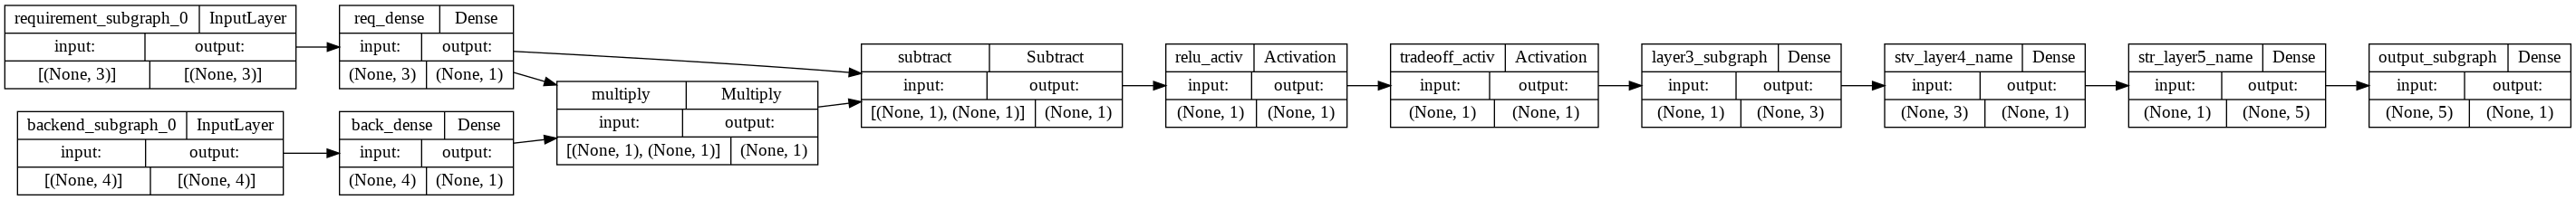

In [21]:
# print to Jupyter notebokk
f_keras_utils_plot_model(fnal_value_graph_model,
           show_shapes=True, 
           show_layer_names=True,
           rankdir = 'LR'
)

## Functionality risk estimation

In [22]:
#
# Computation of the Functionality risk
#
# Functionality risk is an estimated decrease in software product value,
# if a certain backend functionality is not implemented.
#

# NOT USED:
lst_requirement_name = [
    'Acquisition',
    'Validation',
    'Interpretation'
];

lst_backend_name = [
    'cloud infrastructure', 
    'smart watch', 
    'smart phone', 
    '3rd party API'
];
str_all_functionalities_name = 'Implemented all functionalities';

def f_loss_value(fnal_value_graph_model, r, i_array):
    return_loss_value = f_keract_get_activations(
        fnal_value_graph_model,
        [r, numpy_array([i_array])]
    );
    return(return_loss_value);


#
# Input global variable: fl_gl_percentage
#
def f_print_final_value_perctentage(lst_loss_percentage):
    # we are eliminating only bavckend functionalities
    layer_0_names = [lst_backend_name];
    
    # set up the model 'fnal_value_graph_model' 
    fnal_value_graph_model = f_setup_model(lst_model_weights);
    
    # get str_output_name value without str_output_name type
    print("{:.2f}".format(f_loss_value(fnal_value_graph_model, 
                                     vec_R,
                                     [0]*4)[str_output_name][0][0] 
                         ),
          ': Final value with all backend functionalities'
         );

    for layer_0_functionality in range(0,len(layer_0_names)):
        j = int(10 * fl_gl_percentage );
        
        lst_loss_percentage[0][j] = round(
            f_loss_value(fnal_value_graph_model,
                       vec_R,
                       [0]*4
                      )[str_output_name][0][0],
            2
        );

        lst_loss_percentage[0][0] = str_all_functionalities_name;
    
        for i in range(0,len(layer_0_names[layer_0_functionality])):
            funct_array    = [0]*len(layer_0_names[layer_0_functionality]);
            funct_array[i] = 1;
            
            # get name of backend functionality
            lst_loss_percentage[i+1][0] = layer_0_names[
                                                layer_0_functionality
                                            ][i];
            
            # get str_output_name value without str_output_name type
            lst_loss_percentage[i+1][j] = round(
                f_loss_value(fnal_value_graph_model,
                           vec_R,
                           funct_array
                          )[str_output_name][0][0],
                2
            );
            print('  ',
                  # get str_output_name value without str_output_name type
                  "{:.2f}".format( 
                      f_loss_value(fnal_value_graph_model,
                                 vec_R,
                                 funct_array
                                )[str_output_name][0][0] 
                  ),
                  ':',
                  'Without',
                  lst_loss_percentage[i+1][0],
                );

In [23]:
#
# Compute and print risk estimations for percentages from 10% to 90%
#

# initialize 'lst_loss_percentage'
lst_loss_percentage = [[0 for i in range(10)] for j in range(5)];

# Note: fl_gl_percentage is global!
for j in range(0,9):
    fl_gl_percentage = (j+1)/10
    # Write values
    print("\n{:n}% : defined percentage for trade off function".
          format( fl_gl_percentage*100 )
    );
    print("-"*45);
    
    # fl_gl_percentage is parameter defined as GlOBAL variable
    f_print_final_value_perctentage(lst_loss_percentage); 


10% : defined percentage for trade off function
---------------------------------------------
0.09 : Final value with all backend functionalities
   0.00 : Without cloud infrastructure
   0.06 : Without smart watch
   0.09 : Without smart phone
   0.08 : Without 3rd party API

20% : defined percentage for trade off function
---------------------------------------------
0.18 : Final value with all backend functionalities
   0.00 : Without cloud infrastructure
   0.11 : Without smart watch
   0.17 : Without smart phone
   0.17 : Without 3rd party API

30% : defined percentage for trade off function
---------------------------------------------
0.27 : Final value with all backend functionalities
   0.00 : Without cloud infrastructure
   0.16 : Without smart watch
   0.26 : Without smart phone
   0.25 : Without 3rd party API

40% : defined percentage for trade off function
---------------------------------------------
0.36 : Final value with all backend functionalities
   0.00 : Without c

In [24]:
#
# Summary about functionality risk estimation
#
lst_loss_percentage

[['Implemented all functionalities',
  0.09,
  0.18,
  0.27,
  0.36,
  0.44,
  0.53,
  0.62,
  0.71,
  0.8],
 ['cloud infrastructure', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 ['smart watch', 0.06, 0.11, 0.16, 0.2, 0.23, 0.25, 0.26, 0.27, 0.27],
 ['smart phone', 0.09, 0.17, 0.26, 0.34, 0.43, 0.51, 0.59, 0.65, 0.7],
 ['3rd party API', 0.08, 0.17, 0.25, 0.33, 0.4, 0.48, 0.54, 0.59, 0.62]]

In [25]:
#
# Sort functionality risk estimation by 90 % of trade-off function
#
lst_loss_percentage.sort(
    reverse=True,
    key=lambda tradeoff90: tradeoff90[9]
)
lst_loss_percentage

[['Implemented all functionalities',
  0.09,
  0.18,
  0.27,
  0.36,
  0.44,
  0.53,
  0.62,
  0.71,
  0.8],
 ['smart phone', 0.09, 0.17, 0.26, 0.34, 0.43, 0.51, 0.59, 0.65, 0.7],
 ['3rd party API', 0.08, 0.17, 0.25, 0.33, 0.4, 0.48, 0.54, 0.59, 0.62],
 ['smart watch', 0.06, 0.11, 0.16, 0.2, 0.23, 0.25, 0.26, 0.27, 0.27],
 ['cloud infrastructure', 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

## Presenting results

Plot loss values according to skipped items from Backend functionality layer

### Legend is placed inside a plot

0 Implemented all functionalities
1 smart phone
2 3rd party API
3 smart watch
4 cloud infrastructure


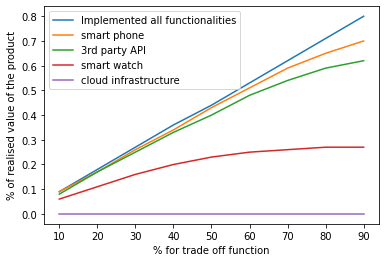

In [26]:
#
# Plot results form 'Rist estimation' computations
#

lst_back_names = [];
for i in range(0,5):
    print(i,lst_loss_percentage[i][0]);
    lst_back_names.append(lst_loss_percentage[i][0]);
    f_matplotlib_pyplot_plot([*range(10,100,10)], lst_loss_percentage[i][1:10]);

f_matplotlib_pyplot_legend(lst_back_names);
f_matplotlib_pyplot_ylabel('% of realised value of the product');
f_matplotlib_pyplot_xlabel('% for trade off function');

f_matplotlib_pyplot_savefig('value_retained.CareHD.pdf');

### Legend is placed outside a plot

Implemented all functionalities
smart phone
3rd party API
smart watch
cloud infrastructure


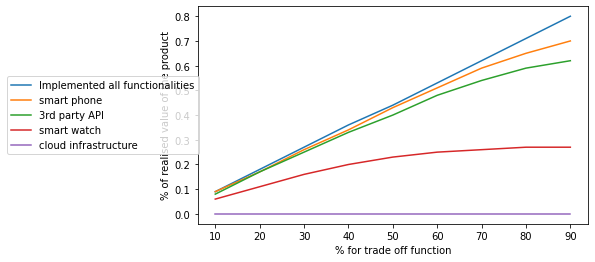

In [27]:
#
# Plot results form 'Risk estimation' computations
#

# define plot size to place legend in the figure during 'savefig'
f_matplotlib_pyplot_figure(figsize=(7,4));

lst_back_names = [];
for i in range(0,5):
    print(lst_loss_percentage[i][0]);
    lst_back_names.append(lst_loss_percentage[i][0]);
    f_matplotlib_pyplot_plot([*range(10,100,10)], lst_loss_percentage[i][1:10]);

# put legend outside a plot
fl_legend_x = -0.5;
fl_legend_y = 0.5;
f_matplotlib_pyplot_ylabel('% of realised value of the product');
f_matplotlib_pyplot_xlabel('% for trade off function');
f_matplotlib_pyplot_legend(lst_back_names, loc='center left', bbox_to_anchor=(fl_legend_x, fl_legend_y))

# bbox_inches = 'tight' : try to figure out the tight bbox of the figure
f_matplotlib_pyplot_savefig('value_retained-left_legend.CareHD.pdf', bbox_inches = 'tight');

Implemented all functionalities
smart phone
3rd party API
smart watch
cloud infrastructure


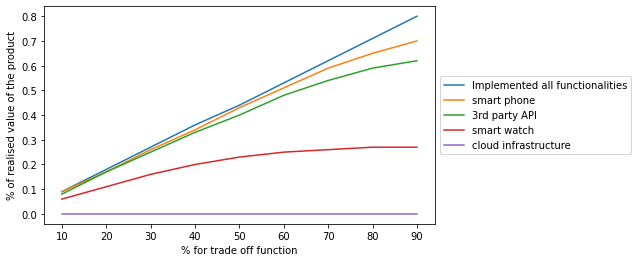

In [28]:
#
# Plot results form 'Risk estimation' computations
#

# define plot size to place legend in the figure during 'savefig'
f_matplotlib_pyplot_figure(figsize=(7,4));

lst_back_names = [];
for i in range(0,5):
    print(lst_loss_percentage[i][0]);
    lst_back_names.append(lst_loss_percentage[i][0]);
    f_matplotlib_pyplot_plot([*range(10,100,10)], lst_loss_percentage[i][1:10]);

# put legend outside a plot
fl_legend_x = 1.0;
fl_legend_y = 0.5;
f_matplotlib_pyplot_ylabel('% of realised value of the product');
f_matplotlib_pyplot_xlabel('% for trade off function');
f_matplotlib_pyplot_legend(lst_back_names, loc='center left', bbox_to_anchor=(fl_legend_x, fl_legend_y))

# bbox_inches = 'tight' : try to figure out the tight bbox of the figure
f_matplotlib_pyplot_savefig('value_retained-right-legend.CareHD.pdf', bbox_inches = 'tight');